<a href="https://colab.research.google.com/github/IlariaSalogni/GeoLing/blob/main/GeoLingIt_Evalita23_Salogni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code for "Salogni at GeoLingIt: Geolocalization by Fine-tuning BERT"

### 0. Requirements


In [ ]:
# REQUIREMENTS
import pandas as pd
import matplotlib.pyplot as plt

!pip install transformers
from transformers import AutoModel, AutoTokenizer #, AutoTokenizer
from transformers import get_scheduler
from transformers import AdamW, get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split

import numpy as np

### 1. Dataset

In [ ]:
# IMPORT DATA
""" The original dataset for subtask b (fine-grained localization) has been given from the task organizators as a TSV file,
 with 4 columns: id, text, latitude, longitude. I first represented this dataset in a pandas dataframe""""

train_file = pd.read_csv('train_b.tsv', sep='\t')
dev_file= pd.read_csv("dev_b.tsv", sep="\t")

# join all the data in a dataframe
df = pd.concat([train_file, dev_file], axis=0, ignore_index=True)
print(len(train_file), len(dev_file), len(df)) #   13500 552 14052 just checking the numbers

# TEXT CLEANING
""" The original dataset, provided by the task organizers, had emojis and users. For GeoLingIt I decided to take them away, while keeping the hashtags"""
import re
def remove_emoji_and_user(text):
    a = re.sub("[^\w\s',]|USER|URL", " ", text)
    return re.sub(' +', ' ', a).strip()

# clean dataset using "remove_emoji_and_user"
df['text'] = df['text'].apply(remove_emoji_and_user)
# inversion of the columns lat and lon
df = df[["id", "text", "longitude", "latitude"]]

# LOOK AT THE DATA
"""scatterplot of the data"""

plt.scatter(df["longitude"], df["latitude"], color='black', label="a single tweet in the Dataset", s=2)
# add title and label to the axis
plt.title('Localization of the dataset')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# add legenda and show
plt.legend()
plt.show()

In [ ]:
# TRAINING-EVAL-TEST SPLIT
""" 20% test set and 80% training/validation; from that 80%, 60% is for training and 40% for validation set """

development_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(development_df, test_size=0.4)

### 2. Building of the model

In [ ]:
# SUB-WORD TOKENIZER, INITIALIZATION OF THE MODEL(S)
""" I first decided to perform the fine-tuning of three different monolingual BERT-based [3] or RoBERTa-based [10] models.
    Here the models and the tokenizers are initialized. (nb: just run one of the three cells, according to the model you want to fine-tune)
    Remove the hashtags if you want to fine-tune the models as they are, without modifying anything (ie without adding output neurons)"""

# 1) UMBERTO
tokenizer = AutoTokenizer.from_pretrained("Musixmatch/umberto-commoncrawl-cased-v1") #CamembertTokenizerFast
#model = AutoModel.from_pretrained("Musixmatch/umberto-commoncrawl-cased-v1")

In [ ]:
# 2) ALBERTO
tokenizer = AutoTokenizer.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
#model = AutoModel.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")

In [ ]:
# 3) BERT BASE ITALIAN
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-italian-cased")
#model = AutoModel.from_pretrained("dbmdz/bert-base-italian-cased")

In [1]:
# ENCODING OF DATA
""" the f. performs the encoding of the input column in the df (that is textual) using the tokenizer of choice (that should already have been initialized);
    it also make the output columns into tensors. You should define "input_col" and "output_cols" before using the function,
    specifing which are your input column and output column(s) in your df"""
def encode_input_and_output(df):
    inputs = tokenizer(df[input_col].tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")
    outputs = torch.Tensor(df[output_cols].values)
    return inputs['input_ids'], inputs['attention_mask'], outputs
    #return {"input_ids": inputs['input_ids'], "attention_mask": inputs['attention_mask'], "labels": outputs}

""" define input and output columns, specifing which are your input column and output column(s) in your df;
    then apply the f. "encode_input_and_output, that calls the tokenizer on the input and makes a tensor of the output"""
input_col = "text"
output_cols = ["latitude", "longitude"]

X_train_ids, X_train_mask, y_train = encode_input_and_output(train_df)
X_val_ids, X_val_mask, y_val = encode_input_and_output(val_df)
X_test_ids, X_test_mask, y_test = encode_input_and_output(test_df)

# MINMAX SCALING
""" the scaler should not be fitted on the whole dataset (only train and val sets should be scaled, and not the test);
    because the test set plays the role of fresh unseen data, so it's not supposed to be accessible at the training stage.
    Using any information coming from the test set before or during training is a potential bias
    in the evaluation of the performance"""
scaler = MinMaxScaler()
y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)

In [ ]:
# CREATE DATA LOADERS
""" Only run this for the "minimal" architecture, as for the others the dataloader is already in the training cell.
    The input data consists of tensors representing the tokenized input sequences (X_train_ids, X_val_ids, X_test_ids) and their corresponding attention masks
    (X_train_mask, X_val_mask, X_test_mask), along with the corresponding labels (y_train_arr, y_val_arr, y_test_arr)"""
batch_size = 64
train_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train_ids), torch.Tensor(X_train_mask),torch.Tensor(y_train_arr))
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_val_ids), torch.Tensor(X_val_mask), torch.Tensor(y_val_arr))
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_test_ids), torch.Tensor(X_test_mask), torch.Tensor(y_test_arr))
test_generator = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# CREATION OF THE MODEL
""" For fine-tuning for regression, I use a class that creates a model with an additional layer sized 2, after the pooling layer.
    This is what I call "minimal" architecture in the paper """
class GeoLocModel(nn.Module):
    def __init__(self, model_name, output_dim):
        super(GeoLocModel, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.fc = nn.Linear(self.bert.config.hidden_size, output_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooler_output = outputs.pooler_output
        return self.fc(pooler_output)

In [ ]:
#again, just run the model of choice
# 1) UMBERTO
model = GeoLocModel("Musixmatch/umberto-commoncrawl-cased-v1", output_dim=2)

In [ ]:
# 2) ALBERTO
model = GeoLocModel("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0", output_dim=2)

In [ ]:
# 3) BERT BASE ITALIAN
model = GeoLocModel("dbmdz/bert-base-italian-cased", output_dim=2)

### 3a. Training and Evaluation: comparing different models on "minimal architecture"
How explained in 2.1 in the paper, to assess how different pre-trained monolingual models
perform on the given dataset, here I first fine-tuned Umberto then Alberto and Bert Base Italian, adding a single linear layer with two output
neurons to the pooling layer of each model, without
activation function, setting the batch size to 50-100-150.

In [ ]:
CUDA_LAUNCH_BLOCKING=1

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
torch.cuda.empty_cache()

# DECIDE THE LEARNING RATE
learning_rate=5e-5
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
#optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

scheduler = get_scheduler("linear", optimizer, num_warmup_steps=0, num_training_steps=len(train_dataset))

# SET BATCH SIZE AND NUMBER OF EPOCHS
batch_size = 50
num_epochs = 10

torch.cuda.empty_cache()

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, batch in enumerate(train_generator):
        optimizer.zero_grad()
        #input_ids, attention_mask, labels = batch[0], batch[1], batch[2]
        input_ids, attention_mask, labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)

        loss_func = torch.nn.MSELoss()
        loss = loss_func(outputs, labels) #qui ci dev'essere un errore di forma

        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

        # empty GPU cache every few batches
        if i % 10 == 0:
          torch.cuda.empty_cache()

    train_loss /= len(train_generator)
    train_losses.append(train_loss)


    # evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for i, batch in enumerate(val_generator):
            input_ids, attention_mask, labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)

            outputs = model(input_ids.long(), attention_mask=attention_mask)
            val_loss += torch.nn.functional.mse_loss(outputs, labels)
            # empty GPU cache every few batches
            if i % 10 == 0:
                torch.cuda.empty_cache()

        val_loss /= len(val_generator)
        val_losses.append(val_loss.item())
        # empty GPU cache every few batches
        if i % 10 == 0:
            torch.cuda.empty_cache()
    print(f"Epoch {epoch+1} - Train loss: {train_loss:.4f}, Val loss: {val_loss.item():.4f}")

# plot the learning curve
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3b. Crossvalidation of Umberto adding a single hidden layer
As in 2.2, to explore the potential benefits of introducing additional
complexity to the model, I designed a new task-specific
architecture adding a single hidden layer right after the
pooling layer, testing different sizes (5 neurons and then
300 neurons) followed by an activation function (Identity,
Sigmoid or ReLU), and finally, a two-neuron output
layer.

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU available. Using CUDA.")
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU.")

# HYPERPARAMETERS FOR THE CROSS VAL
epochs = 10
output_dim = 2
learning_rate=5e-5
batch_sizes = [50] #50, 100, 200
activation_functions = [None, torch.sigmoid, torch.relu]

# 1 HIDDEN LAYERS + UNO DI OUTPUT
neurons = [(3, #input-layer (we don't actually use this because it's the pooling layer, sized 768)
            5, #hidden-layer size
            2), # output-layer (in our case it should be 2)
            (5,300,2)]

# CROSS VALIDATION
cv = KFold(n_splits=2, shuffle=True, random_state=42)

#CICLO COMBINAZIONI NEURONI PER LAYERS:
for combo in neurons:
  # CICLO BATCH
  for batch_size in batch_sizes:

    # CICLO ACTIVATION FUNCTION
      for activation_func in activation_functions:
        train_mean_loss = [] # LISTE PER ERRORE MEDIO SU TUTTI I FOLD di una combinazione BATCH-EPOCHE-ACT. FUNCTION
        val_mean_loss = []

        print(f"----------------------BATCH SIZE: {batch_size} - ACT FUNC: {activation_func}-------------------------")

  #CICLO DELLA CROSS-VAL
        # Esecuzione della cross-validation
        fold_counter = 0
        for train_index, val_index in cv.split(X_train_ids): #PER OGNI FOLD:

            train_losses = [] # LISTE PER PLOT E LEARNING CURVE, SI AGGIORNANO DOPO OGNI FOLD
            val_losses = []
            fold_counter+=1

            print(f"___________________________________FOLD: {fold_counter}__________________________________")

  #MODIFICA PER AGGIUNGERE HIDDEN LAYERS E FARE MLP Regression

            # Creazione del modello per la cross-validation
            cv_model = GeoLocModel("Musixmatch/umberto-commoncrawl-cased-v1", output_dim=output_dim)

            cv_model.to(device)
            print("il modello è stato re-inizializzato")

            if activation_func==None:
              cv_model.fc = nn.Sequential(
                  nn.Linear(768,combo[1]), #1 input layer
                  nn.Linear(combo[1],combo[2]), #1 hidden layer
                  nn.Linear(combo[2], 2), #output layer
                  nn.Identity()).to(device)

            #SIGMOID
            elif activation_func is torch.sigmoid:
              cv_model.fc = nn.Sequential(
                  nn.Linear(768,combo[1]), #1 input layer
                  nn.Linear(combo[1],combo[2]), #1 hidden layer
                  nn.Linear(combo[2], 2), #output layer
                  nn.Sigmoid()).to(device)

            #RELU
            elif activation_func is torch.relu:
              cv_model.fc = nn.Sequential(
                  nn.Linear(768,combo[1]), #1 input layer
                  nn.Linear(combo[1],combo[2]), #1 hidden layer
                  nn.Linear(combo[2], 2), #output layer
                  nn.ReLU()).to(device)

            # Definizione della perdita e dell'ottimizzatore
            optimizer = torch.optim.Adam(cv_model.parameters(), lr=learning_rate)

#DATALOADER
            # Creazione dei dataloader per addestramento e validazione
            train_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train_ids).to(device), torch.Tensor(X_train_mask).to(device),torch.Tensor(y_train_arr).to(device))
            train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_val_ids).to(device), torch.Tensor(X_val_mask).to(device), torch.Tensor(y_val_arr).to(device))
            val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            scheduler = get_scheduler("linear", optimizer, num_warmup_steps=0, num_training_steps=len(train_dataset))

#CICLO EPOCHE
            for epoch in range(epochs):
                cv_model.train()
                train_loss = 0

#TRAIN        # Addestramento del modello
                for i, batch in enumerate(train_generator):
                  optimizer.zero_grad()
                  input_ids, attention_mask, targets = batch[0].to(device), batch[1].to(device), batch[2].to(device)
                  outputs = cv_model(input_ids, attention_mask=attention_mask)

                  loss_func = torch.nn.MSELoss()
                  loss = loss_func(outputs, targets)

                  loss.backward()
                  optimizer.step()
                  scheduler.step()

                  train_loss += loss.item()

                  # empty GPU cache every few batches
                  if i % 10 == 0:
                      torch.cuda.empty_cache()

                train_loss /= len(train_generator)
                train_losses.append(train_loss) #aggiunge train error di ogni epoca, per singolo fold (reset a nuovo fold)
                train_mean_loss.append(train_loss) #aggiunge train error di ogni epoca, per ogni fold nella combinazione

  # TEST        # Valutazione del modello
                cv_model.eval()
                y_target = []
                y_output = []

                with torch.no_grad():
                    val_loss = 0

                    for i, batch in enumerate(val_generator):
                        input_ids, attention_mask, targets = batch[0].to(device), batch[1].to(device), batch[2].to(device)
                        outputs = cv_model(input_ids.long(), attention_mask=attention_mask)
                        val_loss += loss_func(outputs, targets)

                        # empty GPU cache every few batches
                        if i % 10 == 0:
                            torch.cuda.empty_cache()

  #TOGLIAMO MINMAXSCALING per il plot dei valori reali
                        outputs = outputs.cpu()
                        targets = targets.cpu()
                        outputs = scaler.inverse_transform(outputs)
                        targets = scaler.inverse_transform(targets)

  # AGGIUNGIAMO OGNI OUTPUT/TARGET PAIR A LISTE PER PLOT
                        for i in range(len(batch[0])):
                          y_output.append(outputs[i].tolist())
                          y_target.append(targets[i].tolist())

                    val_loss /= len(val_generator)
                    #print(val_loss)
                    val_losses.append(val_loss.item()) #aggiunge evaluation error di ogni epoca, per singolo fold
                    # print(val_losses) nan
                    val_mean_loss.append(val_loss) #aggiunge evaluation error di ogni epoca, per ogni fold

                print(f"Epoch {epoch+1} - Train loss: {train_loss:.4f}, Val loss: {val_loss.item():.4f}")

  #LEARNING CURVE
            plt.plot(train_losses, label='Train')
            plt.plot(val_losses, label='Val')
            if activation_func==None:
              plt.title(f'Learning Curve, batch: {batch_size}, activation: None')
            else:
              plt.title(f'Learning Curve, batch: {batch_size}, activation: Softmax')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

  #SCATTERPLOT
            y_target1, y_target2 = zip(*y_target)
            y_output1, y_output2 = zip(*y_output)
            plt.scatter(y_target1, y_target2, color='black', label='Target', s=3)
            plt.scatter(y_output1, y_output2, color='red', label='Output', s=3)

            # aggiungiamo titolo e label agli assi
            if activation_func==None:
              plt.title(f"targets and outputs, 10 epochs, batch={batch_size}, act. func= Identity, 3 HL ({combo})")
            elif activation_func==torch.sigmoid:
              plt.title(f"targets and outputs, 10 epochs, batch={batch_size}, act. func= Sigmoid, 3 HL ({combo})")
            elif activation_func==torch.relu:
              plt.title(f"targets and outputs, 10 epochs, batch={batch_size}, act. func= ReLU, 3 HL ({combo})")

            plt.xlabel('Longitude')
            plt.ylabel('Latitude')

            # aggiungiamo legenda e mostriamo il grafico
            plt.legend()
            plt.show()

  #ERRORE MEDIO PER TUTTI E 3 I FOLD:
        mean_val_loss = sum(val_mean_loss) / len(val_mean_loss)
        mean_train_loss = sum(train_mean_loss) / len(train_mean_loss)
        print(f"Mean train loss: {mean_train_loss}, Mean eval. loss: {mean_val_loss}")


### 3c. Crossvalidation of Umberto adding more hidden layers
As in 2.3, still with the rationale of knowing whether adding further
complexity would enhance the model’s learning capacity,
I tested a task-specific setting with 3 hidden layers
with neurons in combination (5, 5, 10) (10, 5, 5) and (300,
100, 100) on various activation functions (Identity, Sigmoid,
ReLU) added before the two-neuron output layer.

In [ ]:
# VERSIONE 4,  MLP

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU available. Using CUDA.")
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU.")

# HYPERPARAMETERS FOR CROSSVAL
epochs = 10
output_dim = 2
learning_rate=5e-5
batch_sizes = [100] #50, 100, 200
activation_functions = [None, torch.sigmoid, torch.relu]

# 3 HIDDEN LAYERS + UNO DI OUTPUT
""" select the size of the hidden layer"""
#neurons = [(3,5,5,10,2)]
#neurons = [(3,10,5,5,2)]
neurons = [(3,300,100,100,2)]

# KFOLD CROSSVAL
cv = KFold(n_splits=2, shuffle=True, random_state=42)

#CICLO COMBINAZIONI NEURONI PER LAYERS:
for combo in neurons:
  # CICLO BATCH
  for batch_size in batch_sizes:

    # CICLO ACTIVATION FUNCTION
      for activation_func in activation_functions:
        train_mean_loss = [] # LISTE PER ERRORE MEDIO SU TUTTI I FOLD di una combinazione BATCH-EPOCHE-ACT. FUNCTION
        val_mean_loss = []

        print(f"----------------------BATCH SIZE: {batch_size} - ACT FUNC: {activation_func}-------------------------")

  #CICLO DELLA CROSS-VAL
        # Esecuzione della cross-validation
        fold_counter = 0
        for train_index, val_index in cv.split(X_train_ids): #PER OGNI FOLD:

            train_losses = [] # LISTE PER PLOT E LEARNING CURVE, SI AGGIORNANO DOPO OGNI FOLD
            val_losses = []
            fold_counter+=1

            print(f"___________________________________FOLD: {fold_counter}__________________________________")

  #MODIFICA PER AGGIUNGERE HIDDEN LAYERS E FARE MLP Regression

            # Creazione del modello per la cross-validation
            cv_model = GeoLocModel("Musixmatch/umberto-commoncrawl-cased-v1", output_dim=output_dim)
            #cv_model.fc = nn.Linear(cv_model.bert.config.hidden_size, output_dim)

            cv_model.to(device)
            print("il modello è stato re-inizializzato")

            #NO ACTIVATION FUNCTION
            if activation_func==None:
                cv_model.fc = nn.Sequential(
                    nn.Linear(768,combo[1]), #1 input layer
                    nn.Linear(combo[1],combo[2]), #first hidden layer
                    nn.Linear(combo[2], combo[3]), #second hidden
                    nn.Linear(combo[3], combo[4]), #third hidden
                    nn.Linear(combo[4], 2), #output layer
                    nn.Identity()).to(device)

            #SIGMOID
            elif activation_func is torch.sigmoid:
                cv_model.fc = nn.Sequential(
                    nn.Linear(768,combo[1]), #1 input layer
                    nn.Linear(combo[1],combo[2]), #first hidden layer
                    nn.Linear(combo[2], combo[3]), #second hidden
                    nn.Linear(combo[3], combo[4]), #third hidden
                    nn.Linear(combo[4], 2), #output layer
                    nn.Sigmoid()).to(device)

            #RELU
            elif activation_func is torch.relu:
              cv_model.fc = nn.Sequential(
                  nn.Linear(768,combo[1]), #1 input layer
                    nn.Linear(combo[1],combo[2]), #first hidden layer
                    nn.Linear(combo[2], combo[3]), #second hidden
                    nn.Linear(combo[3], combo[4]), #third hidden
                    nn.Linear(combo[4], 2), #output layer
                  nn.ReLU()).to(device)

            # Definizione della perdita e dell'ottimizzatore
            optimizer = torch.optim.Adam(cv_model.parameters(), lr=learning_rate)

#DATALOADER
            # Creazione dei dataloader per addestramento e validazione
            train_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train_ids).to(device), torch.Tensor(X_train_mask).to(device),torch.Tensor(y_train_arr).to(device))
            train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_val_ids).to(device), torch.Tensor(X_val_mask).to(device), torch.Tensor(y_val_arr).to(device))
            val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            scheduler = get_scheduler("linear", optimizer, num_warmup_steps=0, num_training_steps=len(train_dataset))

#CICLO EPOCHE
            for epoch in range(epochs):
                cv_model.train()
                train_loss = 0

#TRAIN        # Addestramento del modello
                for i, batch in enumerate(train_generator):
                  optimizer.zero_grad()
                  input_ids, attention_mask, targets = batch[0].to(device), batch[1].to(device), batch[2].to(device)
                  outputs = cv_model(input_ids, attention_mask=attention_mask)

                  loss_func = torch.nn.MSELoss()
                  loss = loss_func(outputs, targets)

                  loss.backward()
                  optimizer.step()
                  scheduler.step()

                  train_loss += loss.item()

                  # empty GPU cache every few batches
                  if i % 10 == 0:
                      torch.cuda.empty_cache()

                train_loss /= len(train_generator)
                train_losses.append(train_loss) #aggiunge train error di ogni epoca, per singolo fold (reset a nuovo fold)
                train_mean_loss.append(train_loss) #aggiunge train error di ogni epoca, per ogni fold nella combinazione

  # TEST        # Valutazione del modello
                cv_model.eval()
                y_target = []
                y_output = []

                with torch.no_grad():
                    val_loss = 0

                    for i, batch in enumerate(val_generator):
                        input_ids, attention_mask, targets = batch[0].to(device), batch[1].to(device), batch[2].to(device)
                        outputs = cv_model(input_ids.long(), attention_mask=attention_mask)
                        val_loss += loss_func(outputs, targets)

                        # empty GPU cache every few batches
                        if i % 10 == 0:
                            torch.cuda.empty_cache()

  #TOGLIAMO MINMAXSCALING per il plot dei valori reali
                        outputs = outputs.cpu()
                        targets = targets.cpu()
                        outputs = scaler.inverse_transform(outputs)
                        targets = scaler.inverse_transform(targets)

  # AGGIUNGIAMO OGNI OUTPUT/TARGET PAIR A LISTE PER PLOT
                        for i in range(len(batch[0])):
                          y_output.append(outputs[i].tolist())
                          y_target.append(targets[i].tolist())

                    val_loss /= len(val_generator)
                    #print(val_loss)
                    val_losses.append(val_loss.item()) #aggiunge evaluation error di ogni epoca, per singolo fold
                    # print(val_losses) nan
                    val_mean_loss.append(val_loss) #aggiunge evaluation error di ogni epoca, per ogni fold

                print(f"Epoch {epoch+1} - Train loss: {train_loss:.4f}, Val loss: {val_loss.item():.4f}")

  #LEARNING CURVE
            plt.plot(train_losses, label='Train')
            plt.plot(val_losses, label='Val')
            if activation_func==None:
              plt.title(f'Learning Curve, batch: {batch_size}, activation: None')
            else:
              plt.title(f'Learning Curve, batch: {batch_size}, activation: Softmax')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

  #SCATTERPLOT
            y_target1, y_target2 = zip(*y_target)
            y_output1, y_output2 = zip(*y_output)
            plt.scatter(y_target1, y_target2, color='black', label='Target', s=3)
            plt.scatter(y_output1, y_output2, color='red', label='Output', s=3)

            # aggiungiamo titolo e label agli assi
            if activation_func==None:
              plt.title(f"targets and outputs, 10 epochs, batch={batch_size}, act. func= Identity, 3 HL ({combo})")
            elif activation_func==torch.sigmoid:
              plt.title(f"targets and outputs, 10 epochs, batch={batch_size}, act. func= Sigmoid, 3 HL ({combo})")
            elif activation_func==torch.relu:
              plt.title(f"targets and outputs, 10 epochs, batch={batch_size}, act. func= ReLU, 3 HL ({combo})")

            plt.xlabel('Longitude')
            plt.ylabel('Latitude')

            # aggiungiamo legenda e mostriamo il grafico
            plt.legend()
            plt.show()

  #ERRORE MEDIO PER TUTTI E 3 I FOLD:
        mean_val_loss = sum(val_mean_loss) / len(val_mean_loss)
        mean_train_loss = sum(train_mean_loss) / len(train_mean_loss)
        print(f"Mean train loss: {mean_train_loss}, Mean eval. loss: {mean_val_loss}")


### 4. Error analysis
From the coordinates of the target-output pairs obtained
with the best-performing model (umberto-commoncrawlcased-
v1, "minimal" task-specific architecture, batch 50,
10 epochs), I calculated the error in km using the Haversine
distance.

In [ ]:
#EVALUATION ON TEST SET
""" This part uses the test set, that has not been used yet, while the previous one used the train and evaluation sets"""

# definisci la funzione di loss che vuoi usare
def loss_fn(y_pred, y_true):
    return mean_absolute_error(y_true, y_pred)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# attiva la modalità di valutazione del modello SUL TEST SET
model.eval()

y_target = []
y_output = []
# per ogni batch di dati (43 totali), calcola l'output del modello e la loss
for batch in test_generator:
    input_ids, attention_mask, targets = batch[0].to(device), batch[1].to(device), batch[2].to(device)

    # calcola l'output del modello
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        outputs = outputs.cpu()
        targets = targets.cpu()

    # LOSS FUNCTION
    loss = loss_fn(outputs.tolist(), targets.tolist())
    print(f"Loss: {loss.item()}") #0.80, 0.85 ecc

    #TOGLIAMO MINMAXSCALING
    outputs = scaler.inverse_transform(outputs)
    targets = scaler.inverse_transform(targets)

    # stampa output insieme ai loro valori target
    for i in range(len(batch[0])):
      print(f"Output: {outputs[i].tolist()}, Target: {targets[i].tolist()}")
      y_output.append(outputs[i].tolist())
      y_target.append(targets[i].tolist())


In [ ]:
# SCATTERPLOT TARGET-OUTPUT PAIRS

# estraiamo i valori di y_target e y_output come due liste separate
y_target1, y_target2 = zip(*y_target)
y_output1, y_output2 = zip(*y_output)

# creiamo lo scatterplot

plt.scatter(y_target1, y_target2, color='red', label='Target', s=5)
plt.scatter(y_output1, y_output2, color='blue', label='Output', s=5)

# aggiungiamo titolo e label agli assi
plt.title('Confronto target e output')
plt.xlabel('Valore 1')
plt.ylabel('Valore 2')

# aggiungiamo legenda e mostriamo il grafico
plt.legend()
plt.show()

In [ ]:
# SCATTERPLOT BUT WITH DIFFERENT COLORS FOR HOW MUCH THE TARGET IS AWAY FROM THE OUTPUT

# Calcolo del colore in base alla colonna 'km'
norm = plt.Normalize(df_to['km'].min(), df_to['km'].max())
colors = plt.cm.plasma(norm(df_to['km']))

# Creazione dello scatter plot
plt.scatter(df_to['lon_t'], df_to['lat_t'], c=colors,s=3 )

# Aggiunta della legenda dei colori
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
sm.set_array([])  # La legenda deve avere un array vuoto per funzionare correttamente
cbar = plt.colorbar(sm)
cbar.set_label('km')

# Impostazione dei titoli e delle etichette degli assi
plt.title('Scatter Plot')
plt.xlabel('longitude')
plt.ylabel('latitude')

# Visualizzazione del grafico
plt.show()

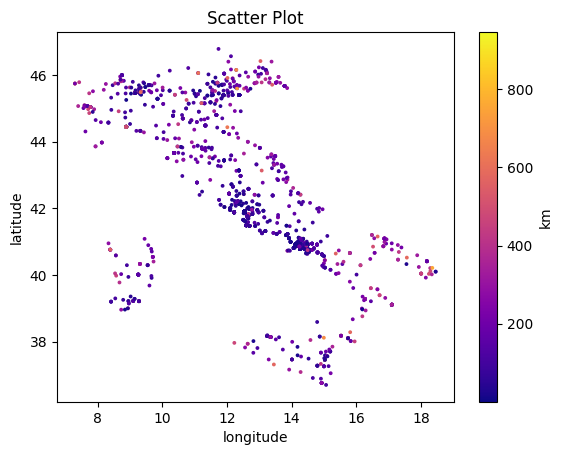

In [ ]:
# HAVERSINE DISTANCE
!pip install haversine
from haversine import haversine, Unit

# y_target e y_output sono liste di tuple come y_target = [(lat1, lon1), (lat2, lon2), ...]
distances = []
for i in range(len(y_target)):
    lat1, lon1 = y_target[i]
    lat2, lon2 = y_output[i]
    distance = haversine((lat1, lon1), (lat2, lon2), unit=Unit.KILOMETERS)
    distances.append(distance)

# la lista "distances" contiene le distanze fra i punti delle due liste
avg_distance = sum(distances) / len(distances)
print(f"Avg distance: {avg_distance} km")
#print(distances)

import pprint
odist = sorted(distances)
pprint.pprint(odist)

In [ ]:
# BARPLOT OF ERROR IN KM (HAVERSINE)
fig, ax = plt.subplots()
ax.bar(range(len(odist)), odist)

ax.set_xlabel('Esempi')
ax.set_ylabel('Distanza')
ax.set_title('Barplot errore in km (Haversine)')

plt.axhline(y=200, xmin=0.1, xmax=0.9)
plt.axhline(y=115, xmin=0.1, xmax=0.9, c="green")

plt.show()

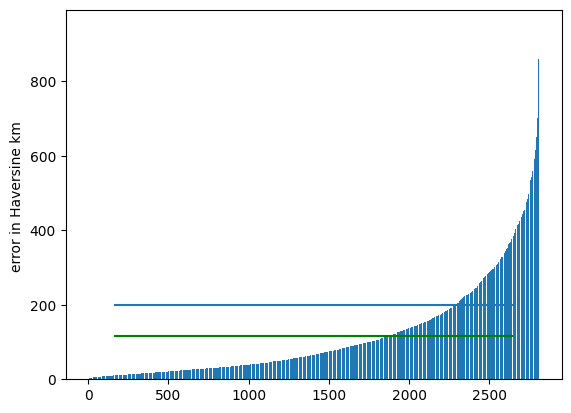

In [ ]:
# HISTOGRAM OF THE ERROR (HAVERSINE)
""" Le barre sono gli intervalli di km """

df_to.km.plot(kind='hist',bins=50) #bins=barre
plt.axvline(df_to['km'].mean(),c='lightblue')
plt.axvline(df_to['km'].quantile(0.50),c='aquamarine',linestyle=':')
plt.axvline(df_to['km'].quantile(0.75),c='lightseagreen', linestyle='--')
plt.axvline(df_to['km'].quantile(0.95),c='paleturquoise')

# Aggiunta della legenda e dei titoli
plt.text(df_to['km'].mean(), 5, f'                                              Mean: {df_to["km"].mean():.2f}', rotation=90, va='bottom')
plt.text(df_to['km'].quantile(0.50), 5, f'                                              Median: {df_to["km"].quantile(0.50):.2f}', rotation=90, va='bottom')
plt.text(df_to['km'].quantile(0.75), 5, f'                                  75th Percentile: {df_to["km"].quantile(0.75):.2f}', rotation=90, va='bottom')
plt.text(df_to['km'].quantile(0.95), 5, f'                                  95th Percentile: {df_to["km"].quantile(0.95):.2f}', rotation=90, va='bottom')

plt.title('Error histogram in km (Haversine)')
plt.xlabel('km')

plt.show()

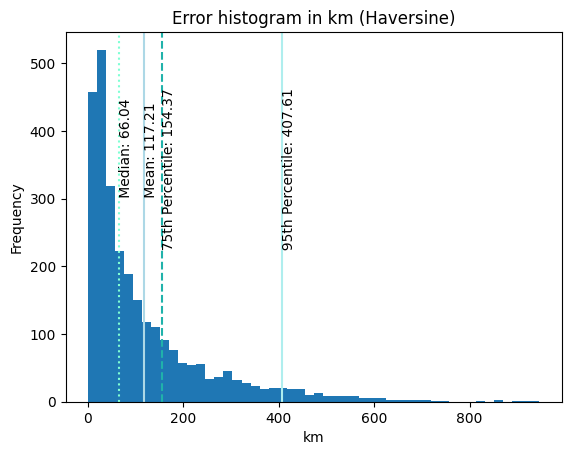